In [432]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import random
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.display.ds9 as ds9
import lsst.afw.table as afwTable

import DiaSourceTools as DSTools
import lsst.afw.display.utils as displayUtils
import lsst.meas.algorithms.detection as sDet

%matplotlib inline

In [305]:
#DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_v11/"
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")

subset = butler.subset("deepDiff_diaSrc")
#file = open("diaSources.txt", "w")
diaSourcesList = []
for dr_subSet in subset:
    if dr_subSet.dataId["ccd"]==14:
        #file.write("visit="+str(dr_subSet.dataId["visit"])+"\n")
        try:
            diaSourcesList.append(dr_subSet)
           
        except:
            pass
            


In [423]:
dataId = {'visit': 800719, 'filter':'r' , 'ccd':14}
diaSrcs = butler.get("deepDiff_diaSrc", dataId)
diffExp = butler.get("deepDiff_differenceExp", dataId)
sciExp  = butler.get("calexp", {"visit":800719, "ccd":14, "filter":"r"})
tmpExp = butler.get("deepDiff_warpedExp", {"visit":800719, "ccd":14, "filter":"r"})
bgConf = sDet.BackgroundConfig()
background,tmpExp = sDet.estimateBackground(tmpExp,bgConf,True)

In [309]:
fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_CircularApertureFlux_6_0_flux")

m_sigma = np.mean(sigmas)
t_sigma = 5*m_sigma

sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_CircularApertureFlux_6_0_flux")

In [424]:
mosaic_dif = displayUtils.Mosaic(gutter=5, background=3, mode="square")
mosaic_sci = displayUtils.Mosaic(gutter=5, background=3, mode="square")
mosaic_tmp = displayUtils.Mosaic(gutter=5, background=3, mode="square")

for i, source in enumerate(sources):
    try:
        dif_stamp = DSTools.get_stamp(source, diffExp)
        
        negFlux   = np.abs(source.get("ip_diffim_PsfDipoleFlux_neg_flux"))
        posFlux   = np.abs(source.get("ip_diffim_PsfDipoleFlux_pos_flux"))
        totalFlux=negFlux+posFlux
        passesFluxNeg = (negFlux / totalFlux)
        passesFluxPos = (posFlux / totalFlux)
        
        mosaic_dif.append(dif_stamp.getMaskedImage(), label=str(i)+"-"+str(source.get("classification_dipole")))
        
        sci_stamp = DSTools.get_stamp(source, sciExp)
        mosaic_sci.append(sci_stamp.getMaskedImage(), label=str(i))

        
        tmp_stamp = DSTools.get_stamp(source, tmpExp)
        mosaic_tmp.append(tmp_stamp.getMaskedImage(), label=str(i))
    except Exception, e:
        print e


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612'



In [425]:
mosaic_dif.makeMosaic(frame=1, title="mosaic_dif")
ds9.setMaskTransparency(100, frame=1)
mosaic_sci.makeMosaic(frame=2, title="mosaic_science")
ds9.setMaskTransparency(100, frame=2)
mosaic_tmp.makeMosaic(frame=3, title="mosaic_template")
ds9.setMaskTransparency(100, frame=3)

In [68]:
ds = sources[0]

In [71]:
ds.get("ip_diffim_NaiveDipoleCentroid_x")

414.459228515625

In [439]:
positive_mask = []
negative_mask = []
mosaic_dif = displayUtils.Mosaic(gutter=5, background=3, mode="square")

label = ""
for source in sources:
    try:
        dif_stamp = DSTools.get_stamp(source, diffExp)

        mi = dif_stamp.getMaskedImage()
        mask = mi.getMask()


        bitmask_detected = mask.getPlaneBitMask("DETECTED")
        bitmask_detected_neg = mask.getPlaneBitMask("DETECTED_NEGATIVE")

        for x in range(0, mi.getWidth()):
            for y in range (0, mi.getHeight()):
                u =  mi.getMask()[x,y]

                if u.get(0,0) & bitmask_detected != 0 and u.get(0,0):
                        positive_mask.append(mi.getImage().get(x,y))
                elif u.get(0,0) & bitmask_detected_neg != 0 and u.get(0,0):
                        negative_mask.append(mi.getImage().get(x,y))

        positive_flux = np.sum(positive_mask)
        negative_flux = np.abs(np.sum(negative_mask))
        total_flux = positive_flux+negative_flux
        print "=========source============"
        print positive_flux/total_flux, negative_flux/total_flux, positive_flux/total_flux + negative_flux/total_flux
        print positive_flux, negative_flux, total_flux
        print source.get("ip_diffim_PsfDipoleFlux_pos_flux"), np.abs(source.get("ip_diffim_PsfDipoleFlux_neg_flux"))
        print source.get("ip_diffim_NaiveDipoleCentroid_x"), source.get("ip_diffim_NaiveDipoleCentroid_y")
        print source.get("ip_diffim_NaiveDipoleCentroid_pos_x"), source.get("ip_diffim_NaiveDipoleCentroid_pos_y")
        print source.get("ip_diffim_NaiveDipoleCentroid_neg_x"), source.get("ip_diffim_NaiveDipoleCentroid_neg_y")
        
        if positive_flux/total_flux < 0.65 and negative_flux/total_flux < 0.65:
            label += "dipole"

        mosaic_dif.append(mi, label=label)

    except Exception, e:
        print e
mosaic_dif.makeMosaic(frame=4, title="mosaic_dif_corrected")
ds9.setMaskTransparency(100, frame=4)

=========source============
0.192442720586 0.807557279414 1.0
1993.54454803 8365.61344956 10359.1579976
7624.72743915 12746.2383982
414.459228516 34.1615562439
418.897766113 24.1649017334
410.020721436 44.1582107544
=========source============
0.723699588889 0.276300411111 1.0
205100.671146 78305.1429448 283405.814091
143773.383137 164699.895497
103.003456116 128.702178955
103.003456116 128.702178955
nan nan
=========source============
0.730332307919 0.269667692081 1.0
211387.315759 78052.5918927 289439.907652
182277.786818 211299.378058
1243.97680664 146.918212891
1243.97680664 146.918212891
nan nan
=========source============
0.843178101771 0.156821898229 1.0
420530.720812 78214.1113042 498744.832117
nan nan
698.862304688 278.428497314
698.821411133 276.105987549
698.903137207 280.75100708
=========source============
0.843044547515 0.156955452485 1.0
424854.139954 79098.0428891 503952.182843
5249.21592579 1213.90352813
510.371948242 314.905639648
509.823303223 319.034545898
510.92062

In [349]:
from lsst.meas.base import SingleFrameMeasurementTask
import lsst.afw.geom as afwGeom
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.ip.diffim import DipoleMeasurementTask

In [362]:
source = sources[13]
dif_stamp = DSTools.get_stamp(source, diffExp)
ds9.mtv(dif_stamp, frame=6)

# DIASource detection and measurement

This code replicates the basic process of detecting a DIASource on a subtracted image using the SourceDetectionTask. In order to get the dipole lobe detection, attribute thresholdPolarity should be set to "both". Next step is to measure such detections (which includes dipoles) in order to get the Fluxes, Sigma and Centroids of all the sources (using the Naive, PSF and Ap Methods).

In [708]:
#test_stamp = dif_stamp.clone()
mosaic_corr_dif = displayUtils.Mosaic(gutter=5, background=3, mode="square")

for i, source in enumerate(sources):
    try:
        test_stamp = DSTools.get_stamp(source, diffExp)
        test_stamp = test_stamp.clone()

        mask  = test_stamp.getMaskedImage().getMask()
        mask &= ~(mask.getPlaneBitMask("DETECTED") | mask.getPlaneBitMask("DETECTED_NEGATIVE"))

        schema = afwTable.SourceTable.makeMinimalSchema()

        #DipoleMeasurementTask.algorithms.names.add('base_PeakLikelihoodFlux')
        DMTask = DipoleMeasurementTask(schema=schema, algMetadata=algMetadata)

        table = afwTable.SourceTable.make(schema)

        config = SourceDetectionTask.ConfigClass()
        config.thresholdPolarity = "both"
        config.thresholdValue = 5.5
        config.reEstimateBackground = False
        config.thresholdType = "pixel_stdev"



        detectionTask = SourceDetectionTask(config=config, schema=schema)

        table = afwTable.SourceTable.make(schema)
        #sources = detectionTask.run(table, exposure, sigma=2).sources
        results = detectionTask.makeSourceCatalog(table=table, exposure=test_stamp , doSmooth=not False )
        DMTask.run(results.sources, test_stamp)
        print "----" + str(i) +"------"
        print len(results.fpSets.positive.getFootprints())
        print len(results.fpSets.negative.getFootprints())

        mosaic_corr_dif.append(test_stamp.getMaskedImage(), label = str(DSTools.get_naive_dipole_probability(source))+"--"+str(i))
    except Exception, e:
        print e

mosaic_corr_dif.makeMosaic(frame=6, title="mosaic_dif_corrected")
ds9.setMaskTransparency(100, frame=6)

----0------
1
2
----1------
1
1
----2------
1
1
----3------
1
1
----4------
1
1
----5------
0
1
----6------
1
0
----7------
2
1
----8------
1
2
----9------
0
1
----10------
1
2
----11------
0
1
----12------
1
1
----13------
1
1
----14------
1
1

  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612'

----16------
0
1
----17------
0
1
---

In [375]:
for s in results.sources:
    flag = s.get("classification_dipole")
    pos = s.get("ip_diffim_PsfDipoleFlux_pos_flux")
    neg = np.abs(s.get("ip_diffim_PsfDipoleFlux_neg_flux"))
    tot = pos+neg
    pos_per = pos/tot
    neg_per = neg/tot
    print flag, pos, neg, tot, pos_per, neg_per

0.0 nan nan nan nan nan
0.0 nan nan nan nan nan


Utility to remove a mask from a stamp and then visualize it.

In [ ]:
# mask  = test_stamp.getMaskedImage().getMask()
mask &= ~(mask.getPlaneBitMask("SAT"))
mask &= ~(mask.getPlaneBitMask("INTRP"))


ds9.mtv(test_stamp, frame=7)

# Detected Objects Study

In [445]:
total = len(sources)
dipoles = 0
nan_dipoles = 0
nan_non_dipoles = 0

naive_dipoles = 0
nan_naive_dipoles = 0
nan_non_naive_dipoles = 0

for s in sources:
        if s.get("classification_dipole") == 1:
            dipoles += 1
            if np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
                nan_dipoles+=1
        elif np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
            nan_non_dipoles += 1
            
        if DSTools.get_naive_dipole_probability(s) > 0:
            naive_dipoles += 1
            if np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
                nan_naive_dipoles+=1
        elif np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
            nan_non_naive_dipoles +=1
            

In [446]:
print total, dipoles, nan_dipoles, nan_non_dipoles
print total, naive_dipoles, nan_naive_dipoles, nan_non_naive_dipoles

24 5 0 10
24 11 4 6


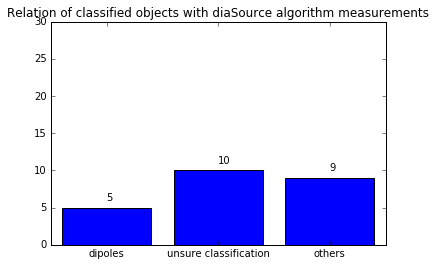

In [549]:
psf_flux_data = [dipoles, nan_non_dipoles, total-(dipoles+nan_non_dipoles)]
labels = ('dipoles', 'unsure classification','others')

ind = np.arange(len(psf_flux_data))

p1 = plt.bar(ind, psf_flux_data, align='center')
ax = plt.axes()



plt.xticks(ind, labels)
plt.yticks(np.arange(0, total+10, 5))
plt.title("Relation of classified objects with diaSource algorithm measurements")


for i, rect in enumerate(p1):
    plt.text(rect.get_x()+rect.get_width()/2.,rect.get_height()+1, int(rect.get_height()))

    
plt.show()

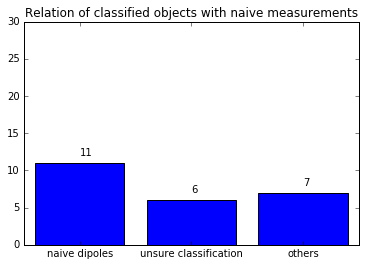

In [550]:
psf_flux_data = [naive_dipoles, nan_non_naive_dipoles, total-(naive_dipoles+nan_non_naive_dipoles)]
labels = ('naive dipoles', 'unsure classification','others')

ind = np.arange(len(psf_flux_data))

p1 = plt.bar(ind, psf_flux_data, align='center')
ax = plt.axes()

plt.xticks(ind, labels)

plt.yticks(np.arange(0, total+10, 5))
plt.title("Relation of classified objects with naive measurements")

for i, rect in enumerate(p1):
    plt.text(rect.get_x()+rect.get_width()/2.,rect.get_height()+1, int(rect.get_height()))
    
plt.show()

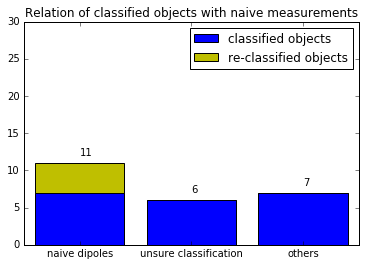

In [551]:
psf_flux_data = [naive_dipoles-nan_naive_dipoles, nan_non_naive_dipoles, total-(naive_dipoles+nan_non_naive_dipoles)]
psf_flux_extra_data = [nan_naive_dipoles, 0, 0]

labels = ('naive dipoles', 'unsure classification','others')

ind = np.arange(len(psf_flux_data))

p1 = plt.bar(ind, psf_flux_data, align='center')
ax = plt.axes()




p2 =plt.bar(ind, psf_flux_extra_data, color='y', align='center', bottom=psf_flux_data)
plt.xticks(ind, labels)
plt.legend((p1[0], p2[0]), ('classified objects','re-classified objects'))
plt.yticks(np.arange(0, total+10, 5))
plt.title("Relation of classified objects with naive measurements")

for rect1, rect2 in zip(p1, p2):
    plt.text(rect1.get_x()+rect1.get_width()/2.,rect2.get_height()+rect1.get_height()+1, int(rect1.get_height()+rect2.get_height()))

    
plt.show()

In [506]:
diffExp.getXY0()

Point2I(0, 0)

In [512]:
print sciExp.getHeight(), sciExp.getWidth()

4612 2048


Source # 0
negative lobe
0.255319148936 47
75% of sources contribute 96.4544287327% of total flux
50% of sources contribute 85.3700767001% of total flux
25% of sources contribute 66.0987247784% of total flux
10% of sources contribute 44.9781771636% of total flux


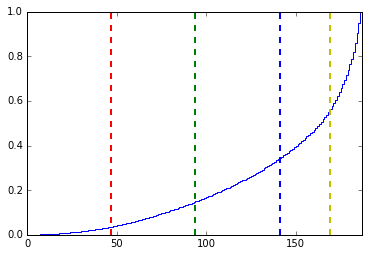

positive lobe
0.254716981132 26
75% of sources contribute 95.3446063204% of total flux
50% of sources contribute 81.1061810297% of total flux
25% of sources contribute 57.0363769536% of total flux
10% of sources contribute 30.0488366419% of total flux


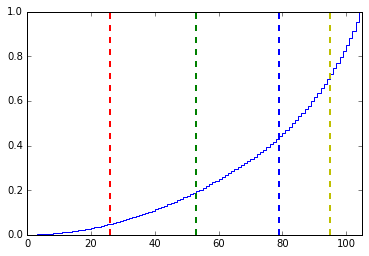

Source # 1
negative lobe
0.253164556962 59
75% of sources contribute 99.519728859% of total flux
50% of sources contribute 97.1768583209% of total flux
25% of sources contribute 81.3225826852% of total flux
10% of sources contribute 47.9971503395% of total flux


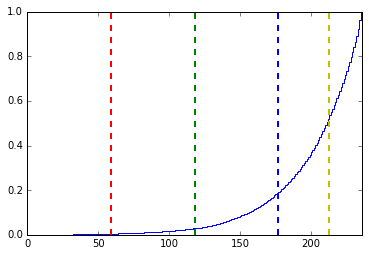

positive lobe
0.251308900524 191
75% of sources contribute 99.2830989804% of total flux
50% of sources contribute 97.2277369771% of total flux
25% of sources contribute 91.9436309931% of total flux
10% of sources contribute 74.2303640182% of total flux


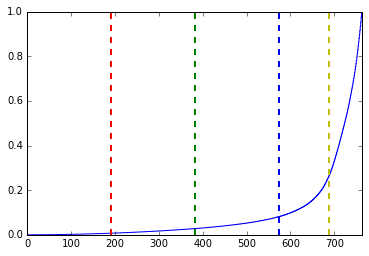

Source # 2
negative lobe
0.257731958763 24
75% of sources contribute 99.6850561885% of total flux
50% of sources contribute 98.5543463942% of total flux
25% of sources contribute 92.708211155% of total flux
10% of sources contribute 72.3110330277% of total flux


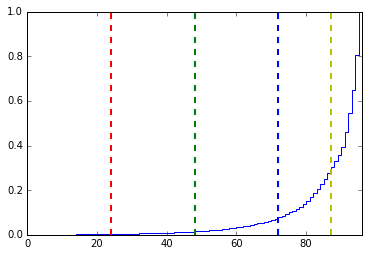

positive lobe
0.25321888412 58
75% of sources contribute 99.3842203503% of total flux
50% of sources contribute 97.5295637074% of total flux
25% of sources contribute 93.551742834% of total flux
10% of sources contribute 84.2571019848% of total flux


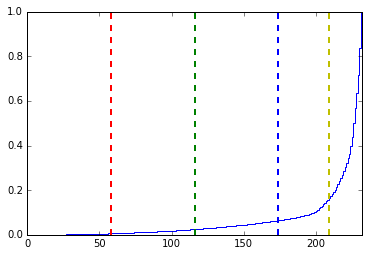

Source # 3
negative lobe
0.259259259259 13
75% of sources contribute 99.383659911% of total flux
50% of sources contribute 96.5943689246% of total flux
25% of sources contribute 88.2302104324% of total flux
10% of sources contribute 64.1658028258% of total flux


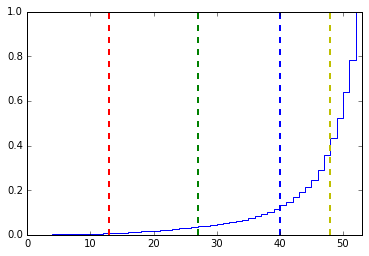

positive lobe
0.252336448598 80
75% of sources contribute 99.6730291762% of total flux
50% of sources contribute 98.694589454% of total flux
25% of sources contribute 96.8397191319% of total flux
10% of sources contribute 92.5678580384% of total flux


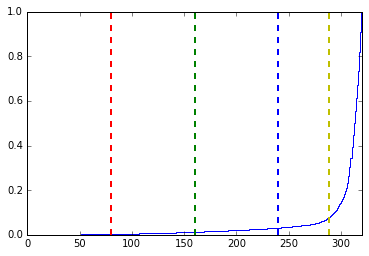

Source # 4
negative lobe
0.263157894737 14
75% of sources contribute 94.3300284975% of total flux
50% of sources contribute 75.5253854082% of total flux
25% of sources contribute 44.7235259386% of total flux
10% of sources contribute 19.4514161673% of total flux


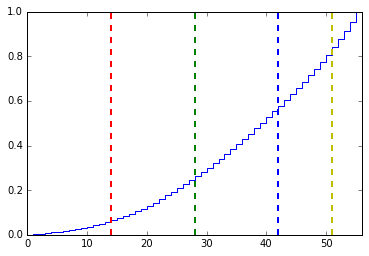

positive lobe
0.264705882353 17
75% of sources contribute 98.6782426913% of total flux
50% of sources contribute 94.8732296021% of total flux
25% of sources contribute 88.0833270512% of total flux
10% of sources contribute 81.7840937879% of total flux


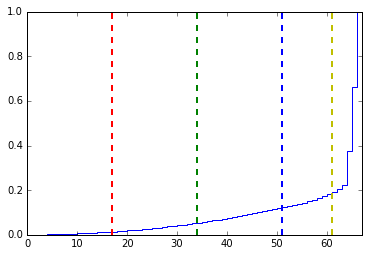

Source # 5
negative lobe
0.254901960784 12
75% of sources contribute 92.4817221461% of total flux
50% of sources contribute 74.3369233926% of total flux
25% of sources contribute 46.7171922427% of total flux
10% of sources contribute 25.1892897201% of total flux


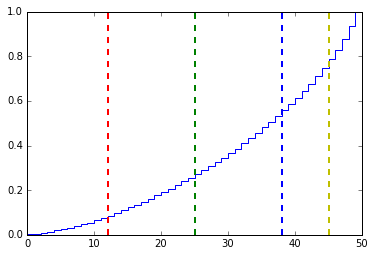

positive lobe
No values for mask DETECTED
Source # 6
negative lobe
No values for mask DETECTED_NEGATIVE
positive lobe
0.253086419753 81
75% of sources contribute 93.1149078643% of total flux
50% of sources contribute 75.4562962818% of total flux
25% of sources contribute 46.3823508175% of total flux
10% of sources contribute 22.3117839317% of total flux


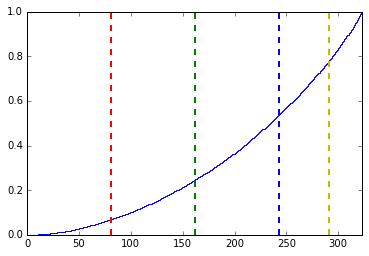

Source # 7
negative lobe
0.259615384615 26
75% of sources contribute 98.9566692464% of total flux
50% of sources contribute 94.7297229328% of total flux
25% of sources contribute 79.3119663663% of total flux
10% of sources contribute 57.444833547% of total flux


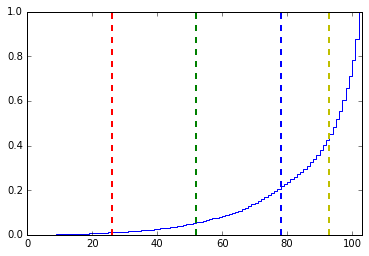

positive lobe
0.250533049041 234
75% of sources contribute 97.1274849044% of total flux
50% of sources contribute 88.7689943401% of total flux
25% of sources contribute 73.4808023798% of total flux
10% of sources contribute 54.8821922952% of total flux


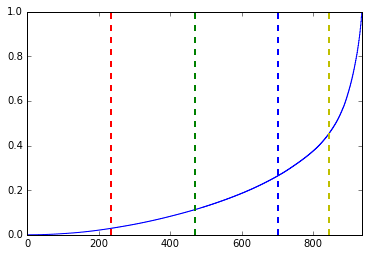

Source # 8
negative lobe
0.253731343284 33
75% of sources contribute 98.9142224659% of total flux
50% of sources contribute 94.2555266678% of total flux
25% of sources contribute 71.0693719428% of total flux
10% of sources contribute 39.7633048197% of total flux


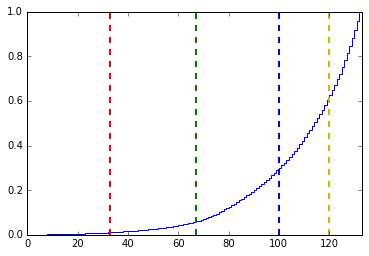

positive lobe
0.251088534107 172
75% of sources contribute 98.6146910589% of total flux
50% of sources contribute 94.6443348554% of total flux
25% of sources contribute 87.4033573956% of total flux
10% of sources contribute 77.1749066177% of total flux


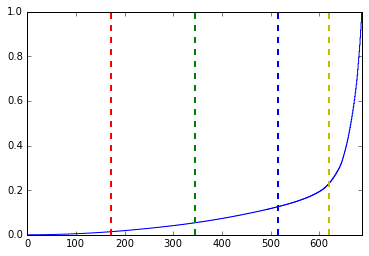

Source # 9
negative lobe
0.266666666667 15
75% of sources contribute 97.7977702806% of total flux
50% of sources contribute 91.5254242095% of total flux
25% of sources contribute 79.5246521314% of total flux
10% of sources contribute 56.8353118425% of total flux


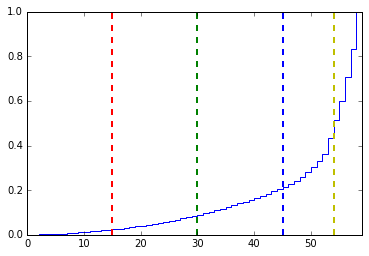

positive lobe
No values for mask DETECTED
Source # 10
negative lobe
0.260869565217 17
75% of sources contribute 98.8904645613% of total flux
50% of sources contribute 93.8381345446% of total flux
25% of sources contribute 78.1440167574% of total flux
10% of sources contribute 47.265114295% of total flux


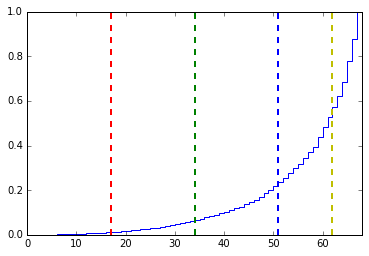

positive lobe
0.250875145858 214
75% of sources contribute 98.4527521887% of total flux
50% of sources contribute 94.1650107696% of total flux
25% of sources contribute 86.3288203792% of total flux
10% of sources contribute 74.7677422755% of total flux


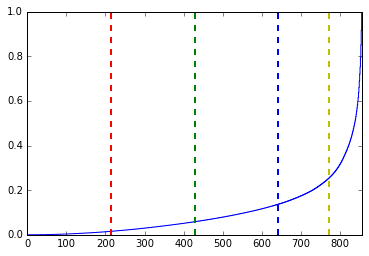

Source # 11
negative lobe
0.250803858521 77
75% of sources contribute 94.073384779% of total flux
50% of sources contribute 76.978178565% of total flux
25% of sources contribute 47.9043217344% of total flux
10% of sources contribute 22.8679795235% of total flux


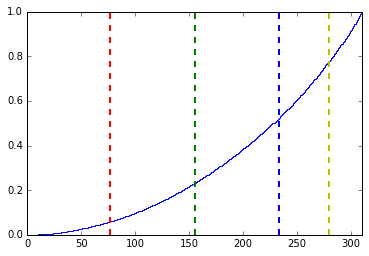

positive lobe
No values for mask DETECTED
Source # 12
negative lobe
0.252336448598 26
75% of sources contribute 98.7639305347% of total flux
50% of sources contribute 89.498770161% of total flux
25% of sources contribute 63.0461729427% of total flux
10% of sources contribute 33.152427814% of total flux


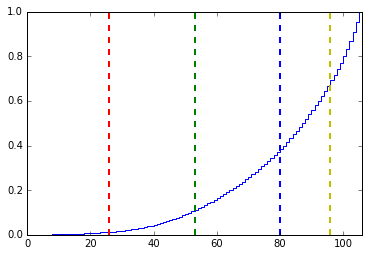

positive lobe
0.250877192982 285
75% of sources contribute 98.6538113053% of total flux
50% of sources contribute 94.6810455623% of total flux
25% of sources contribute 87.2606923065% of total flux
10% of sources contribute 78.1086701835% of total flux


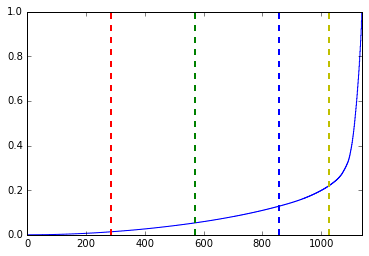

Source # 13
negative lobe
0.256637168142 28
75% of sources contribute 99.1267428198% of total flux
50% of sources contribute 96.4131738114% of total flux
25% of sources contribute 87.5047024865% of total flux
10% of sources contribute 59.8403053207% of total flux


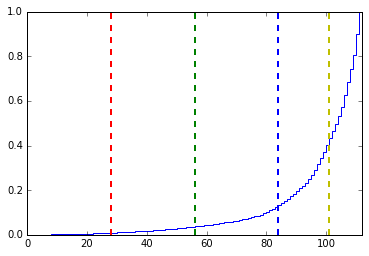

positive lobe
0.255319148936 35
75% of sources contribute 98.4450373772% of total flux
50% of sources contribute 94.4805109619% of total flux
25% of sources contribute 85.3540658614% of total flux
10% of sources contribute 63.9912179759% of total flux


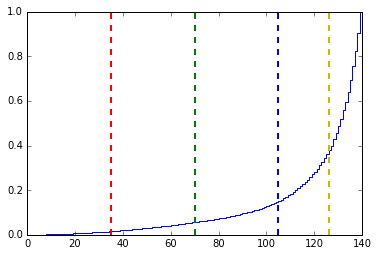

Source # 14
negative lobe
0.252747252747 22
75% of sources contribute 99.74022283% of total flux
50% of sources contribute 98.802208874% of total flux
25% of sources contribute 95.9736544164% of total flux
10% of sources contribute 83.1688719029% of total flux


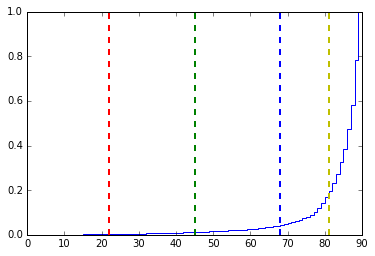

positive lobe
0.252032520325 30
75% of sources contribute 99.7180103979% of total flux
50% of sources contribute 98.7876688962% of total flux
25% of sources contribute 96.705660508% of total flux
10% of sources contribute 90.7190007181% of total flux


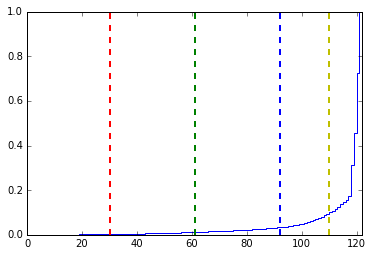

Source # 15

  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1966,1713),Extent2I(85,178)) doesn't fit in image 2048x4612'

Source # 16
negative lobe
0.263888888889 18
75% of sources contribute 98.2854800347% of total flux
50% of sources contribute 91.483238809% of total flux
25% of sources contribute 77.5911974581% of total flux
10% of sources contribute 61.7601682131% of total flux


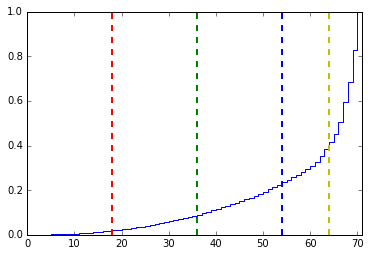

positive lobe
No values for mask DETECTED
Source # 17
negative lobe
0.28125 8
75% of sources contribute 92.9831015402% of total flux
50% of sources contribute 77.3632907535% of total flux
25% of sources contribute 47.7013299555% of total flux
10% of sources contribute 26.8107810853% of total flux


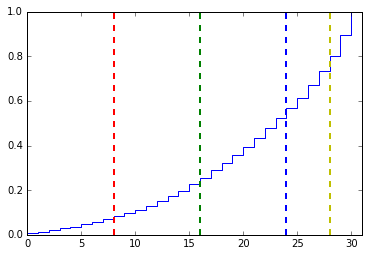

positive lobe
No values for mask DETECTED
Source # 18
negative lobe
0.255102040816 49
75% of sources contribute 95.5601154277% of total flux
50% of sources contribute 81.2281280211% of total flux
25% of sources contribute 55.6994121472% of total flux
10% of sources contribute 31.8556170603% of total flux


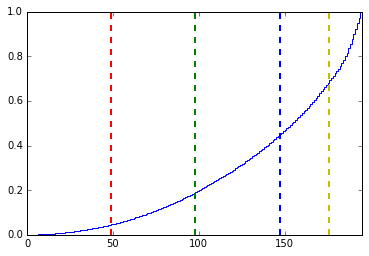

positive lobe
No values for mask DETECTED
Source # 19
negative lobe
0.251612903226 38
75% of sources contribute 99.739477036% of total flux
50% of sources contribute 98.5821571804% of total flux
25% of sources contribute 94.3694916344% of total flux
10% of sources contribute 77.8251036907% of total flux


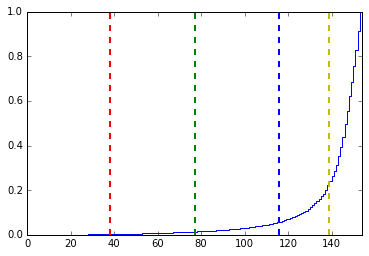

positive lobe
0.253112033195 60
75% of sources contribute 99.5634521716% of total flux
50% of sources contribute 98.304537955% of total flux
25% of sources contribute 95.6219807985% of total flux
10% of sources contribute 86.1590396342% of total flux


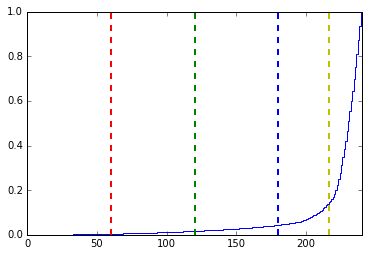

Source # 20
negative lobe
0.251700680272 36
75% of sources contribute 99.7923602286% of total flux
50% of sources contribute 98.9847733258% of total flux
25% of sources contribute 95.3373685397% of total flux
10% of sources contribute 76.4923659053% of total flux


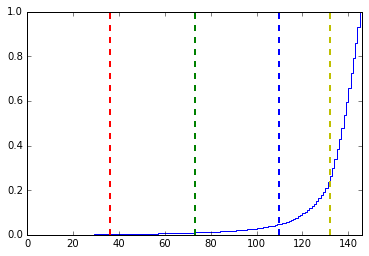

positive lobe
0.251968503937 31
75% of sources contribute 99.0646533629% of total flux
50% of sources contribute 96.7530855831% of total flux
25% of sources contribute 92.2878084687% of total flux
10% of sources contribute 85.4185804805% of total flux


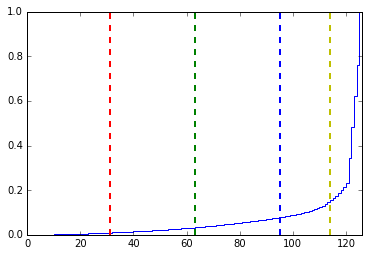

Source # 21
negative lobe
0.260273972603 18
75% of sources contribute 96.6952665004% of total flux
50% of sources contribute 88.3180327441% of total flux
25% of sources contribute 73.3594325626% of total flux
10% of sources contribute 47.8634678213% of total flux


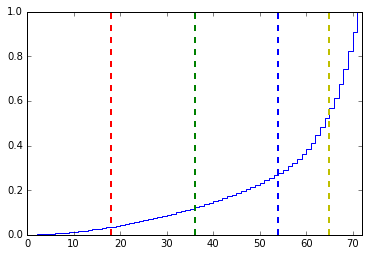

positive lobe
0.252525252525 24
75% of sources contribute 98.2602259555% of total flux
50% of sources contribute 92.3226711844% of total flux
25% of sources contribute 81.2902257295% of total flux
10% of sources contribute 60.0783943758% of total flux


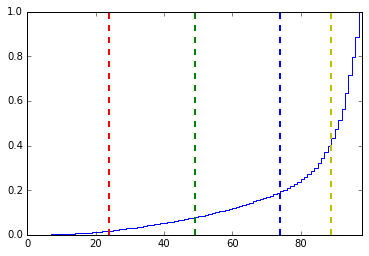

Source # 22
negative lobe
0.255681818182 44
75% of sources contribute 99.8039851509% of total flux
50% of sources contribute 99.1120182525% of total flux
25% of sources contribute 97.0209551475% of total flux
10% of sources contribute 83.8836285299% of total flux


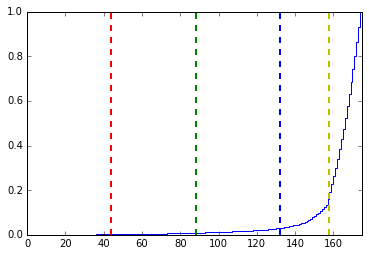

positive lobe
0.268292682927 10
75% of sources contribute 96.7712995091% of total flux
50% of sources contribute 90.2217782854% of total flux
25% of sources contribute 78.912449944% of total flux
10% of sources contribute 60.6889360157% of total flux


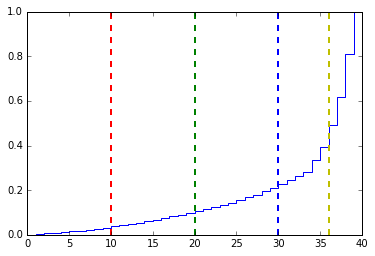

Source # 23
negative lobe
0.253246753247 38
75% of sources contribute 99.7119485598% of total flux
50% of sources contribute 98.6026788631% of total flux
25% of sources contribute 95.0029088601% of total flux
10% of sources contribute 79.1187925375% of total flux


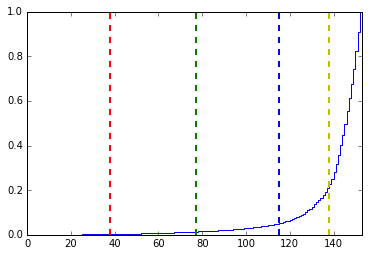

positive lobe
0.258064516129 31
75% of sources contribute 99.6118940083% of total flux
50% of sources contribute 98.4323711356% of total flux
25% of sources contribute 95.5130626012% of total flux
10% of sources contribute 87.5024717579% of total flux


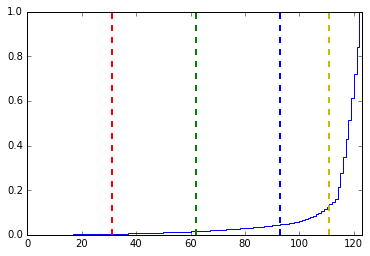

In [676]:
for i, s in enumerate(sources):
    try:
        print "Source # "+ str(i)
        te_stamp = DSTools.get_stamp(s, diffExp)
        print "negative lobe"
        plot_cumulative_flux(te_stamp, "DETECTED_NEGATIVE", positive=False)
        print "positive lobe"
        plot_cumulative_flux(te_stamp, "DETECTED")
    except Exception, e:
        print e

In [699]:
def plot_cumulative_flux(stamp, plane_mask="DETECTED", positive=True):

    mi = stamp.getMaskedImage()
    m = mi.getMask()
    values = []
    for x in range(stamp.getWidth()):
        for y in range(stamp.getHeight()):
            
            planeb_mask = mask.getPlaneBitMask(plane_mask)
            
            val = mi.getImage().get(x,y)
         
            if planeb_mask & m[x,y].get(0,0) != 0:
                #print mi.get(x,y)
                
                if positive:
                    if val > 0:
                        values.append(np.abs(val))
                else:
                    if val < 0:
                        values.append(np.abs(val))
                        
        
    if len(values) > 0:           
        values.sort(reverse=True)
      


        base = [i for i in range(len(values))]
        
        
        cumulative = np.cumsum(values)
        cumulative = cumulative/cumulative[-1]
          
        first = False
        f = 0
        second = False
        s = 0
        third = False
        t = 0
        forth = False
        fo = 0
        for val, b in zip(cumulative, base):
            if not forth and float(b+1) / float(base[-1]+1) > 0.90:
                print "10% of sources contribute " +str((1.0-val)*100)+ "% of total flux"
                forth = True
                fo=b
            
            if not first and float(b+1) / float(base[-1]+1) > 0.25:
                print float(b+1) / float(base[-1]+1), b
                print "75% of sources contribute " +str((1.0-val)*100)+ "% of total flux"
                first = True
                f=b
            if not second and float(b+1) / float(base[-1]+1) > 0.50:
                print "50% of sources contribute " +str((1.0-val)*100)+ "% of total flux"
                second = True
                s=b
            if not third and float(b+1) / float(base[-1]+1) > 0.75:
                print "25% of sources contribute " +str((1.0-val)*100)+ "% of total flux"
                third = True
                t=b
            
        plt.step(base, cumulative)
        axes = plt.axes()
        axes.set_xlim(xmax = base[-1])
        
        plt.axvline(f, color='r', linestyle='dashed', linewidth=2)
        plt.axvline(s, color='g', linestyle='dashed', linewidth=2)
        plt.axvline(t, color='b', linestyle='dashed', linewidth=2)
        plt.axvline(fo, color='y', linestyle='dashed', linewidth=2)
        
        plt.show()
    else:
        print "No values for mask "+ plane_mask
                

negative lobe
0.28125 8
75% of sources contribute 43.5002469468% of total flux
50% of sources contribute 17.2379765612% of total flux
25% of sources contribute 4.73565477647% of total flux
10% of sources contribute 1.23802131736% of total flux


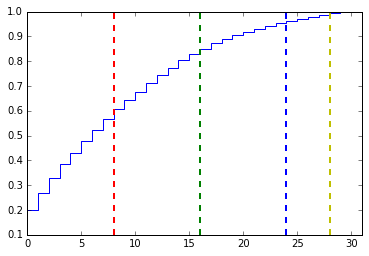

positive lobe
No values for mask DETECTED


In [701]:
te_stamp = DSTools.get_stamp(sources[17], diffExp)
print "negative lobe"
plot_cumulative_flux(te_stamp, "DETECTED_NEGATIVE", positive=False)
print "positive lobe"
plot_cumulative_flux(te_stamp, "DETECTED")

In [683]:
im =background.getImageF()
im_array = im.getArray()

In [698]:
print np.mean(im_array), np.std(im_array),  np.std(im_array)*np.sqrt(im_array.size)

578.963 4.08305 12548.5688607


In [689]:
print im_array.shape
im_array.size

(4612, 2048)


9445376

In [697]:
bkg_science = butler.get("calexpBackground", {"visit":800719, "ccd":14, "filter":"r"})

bkg_im = bkg_science.getImage()
bkg_array = bkg_im.getArray()

print np.mean(bkg_array), np.std(bkg_array), np.std(bkg_array)*np.sqrt(bkg_array.size)

560.452 4.37297 13439.5847293


In [696]:
bkg_science.getImage()

<lsst.afw.image.imageLib.ImageF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::Image< float > > *' at 0x7fdf5b8e71b0> >

# SERIALIZATION TESTS

In [585]:
stamp1 = DSTools.get_stamp(sources[23], sciExp, offset=30)
stamp2 = DSTools.get_stamp(sources[23], tmpExp, offset=30)

In [586]:
ds9.mtv(stamp1, frame=10)

In [587]:
stamp1.writeFits("science.fits")
stamp2.writeFits("template.fits")

In [589]:
masks = [[0 for x in range(stamp2.getHeight())]for y in range(stamp2.getWidth())]

In [596]:
mi = stamp2.getMaskedImage()
m = mi.getMask()

for x in range(stamp2.getHeight()):
    for y in range(stamp2.getWidth()):
        p_mask = m.getPlaneBitMask("DETECTED")
        val = m[x,y].get(0,0)
        if val & p_mask != 0:
            masks[x][y] = 1
        

In [598]:
import pickle

In [601]:
pickle.dump(masks, open("mask.p", "wb"))